In [1]:
import os
import utility
import torch
import torch.nn as nn
from importlib import import_module
import datetime
import torch.optim as optim
from models import *

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [2]:
class trainArgs:
    gpu_id = 0
    net = 'STMFNet'
    data_dir = 'D:/stmfnet_data'
    out_dir = './train_results'
    load = None
    epochs = 70
    batch_size = 2
    loss = "1*Lap"
    patch_size = 256
    lr = 0.001
    lr_decay = 20
    decay_type = 'step'
    gamma = 0.5
    patience = None
    optimizer = 'ADAMax'
    weight_decay = 0
    featc = [64, 128, 256, 512]
    featnet = 'UMultiScaleResNext'
    featnorm = 'batch'
    kernel_size = 5
    dilation = 1
    finetune_pwc = False

args=trainArgs()

In [3]:
from data.datasets import *
from torch.utils.data import DataLoader

torch.cuda.set_device(args.gpu_id)

# training sets
vimeo90k_train = Vimeo90k_quintuplet(
    join(args.data_dir, "vimeo_septuplet"),
    train=True,
    crop_sz=(args.patch_size, args.patch_size),
)
bvidvc_train = BVIDVC_quintuplet(
    join(args.data_dir, "bvidvc"), crop_sz=(args.patch_size, args.patch_size)
)

# validation set
vimeo90k_valid = Vimeo90k_quintuplet(
    join(args.data_dir, "vimeo_septuplet"),
    train=False,
    crop_sz=(args.patch_size, args.patch_size),
    augment_s=False,
    augment_t=False,
)

datasets_train = [vimeo90k_train, bvidvc_train]
train_sampler = Sampler(datasets_train, iter=True)

# data loaders
train_loader = DataLoader(
    dataset=train_sampler, batch_size=args.batch_size, shuffle=True, num_workers=0
)
valid_loader = DataLoader(
    dataset=vimeo90k_valid, batch_size=args.batch_size, num_workers=0
)

In [4]:
# Load the model


torch.cuda.set_device(args.gpu_id)

if not os.path.exists(args.out_dir):
    os.mkdir(args.out_dir)

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# def load_model(filepath):

#     checkpoint = torch.load(filepath)
#     model = STMFNet(args).cuda()
#     model.load_state_dict(checkpoint['state_dict'])
    
#     return model

# model = load_model("./models/stmfnet.pth")

teacher = to_device(STMFNet(args), device)
teacher.to(device)
checkpoint = torch.load('./models/stmfnet.pth')
teacher.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

### `distiller.py`

In [5]:
import os
import utility
import torch
import torch.nn as nn

class Distiller:
    def __init__(self, args, train_loader, valid_loader, student, teacher, loss, distill_optimizer, start_epoch=0):
        self.args = args
        self.train_loader = train_loader
        self.max_step = self.train_loader.__len__()
        self.valid_loader = valid_loader
        self.student = student
        self.teacher = teacher
        self.loss = loss
        self.distill_optimizer = distill_optimizer
        self.current_epoch = start_epoch

        self.optimizer = utility.make_optimizer(args, self.student)
        self.scheduler = utility.make_scheduler(args, self.optimizer)

        self.out_dir = args.out_dir
        if not os.path.exists(args.out_dir):
            os.makedirs(args.out_dir)
        self.ckpt_dir = os.path.join(args.out_dir, "checkpoint")
        if not os.path.exists(self.ckpt_dir):
            os.makedirs(self.ckpt_dir)

        self.logfile = open(os.path.join(args.out_dir, "log.txt"), "a", buffering=1)
        self.logfile.write(
            "\n********STARTING FROM EPOCH {}********\n".format(self.current_epoch)
        )

    def train(self):
        # Train
        self.student.train()
        psnr_list = []
        for batch_idx, (frame1, frame3, frame4, frame5, frame7) in enumerate(
            self.train_loader, 1
        ):
            self.optimizer.zero_grad()

            frame1 = frame1.cuda()
            frame3 = frame3.cuda()
            frame5 = frame5.cuda()
            frame7 = frame7.cuda()
            frame4 = frame4.cuda()

            output = self.student(frame1, frame3, frame5, frame7)
            targets = teacher(frame1, frame3, frame5, frame7)

            loss = self.loss(output, targets, [frame3, frame5])
            self.distill_optimizer.zero_grad()
            
            
            # print(type(self.loss))
            
            # print('loss ',batch_idx,': ',loss)
            # print('frame1: ', frame1)
            
            
            loss.backward()
            self.distill_optimizer.step()

            psnr_list.append(
                utility.calc_psnr(frame4, output["frame1"]).detach()
            )  # (B,)
            if batch_idx % max((self.max_step // 5), 1) == 0:
                msg = "{:<13s}{:<14s}{:<6s}{:<16s}{:<12s}{:<20.16f}".format(
                    "Train Epoch: ",
                    "["
                    + str(self.current_epoch + 1)
                    + "/"
                    + str(self.args.epochs)
                    + "]",
                    "Step: ",
                    "[" + str(batch_idx) + "/" + str(self.max_step) + "]",
                    "train loss: ",
                    loss.item(),
                )
                print(msg)
                self.logfile.write(msg + "\n")

        self.cur_train_psnr = torch.cat(psnr_list).mean().item()

        self.current_epoch += 1
        if self.args.decay_type != "plateau":
            self.scheduler.step()

    def validate(self):
        # Validate
        self.student.eval()
        psnr_list, ssim_list = [], []
        for frame1, frame3, frame4, frame5, frame7 in self.valid_loader:
            with torch.no_grad():
                frame1 = frame1.cuda()
                frame3 = frame3.cuda()
                frame5 = frame5.cuda()
                frame7 = frame7.cuda()
                frame4 = frame4.cuda()

                output = self.student(frame1, frame3, frame5, frame7)

            psnr_list.append(utility.calc_psnr(frame4, output))  # (B,)
            ssim_list.append(utility.calc_ssim(frame4, output))  # (B,)

        psnr = torch.cat(psnr_list).mean().item()
        ssim = torch.cat(ssim_list).mean().item()
        msg = (
            "Train Epoch: "
            + "["
            + str(self.current_epoch)
            + "/"
            + str(self.args.epochs)
            + "]\t"
            + "Train PSNR: "
            + "{:<3.2f}\t".format(self.cur_train_psnr)
            + "Valid PSNR: "
            + "{:<3.2f}".format(psnr)
            + "Valid SSIM: "
            + "{:<3.2f}".format(ssim)
        )
        print(msg)
        self.logfile.write(msg + "\n")
        if self.args.decay_type == "plateau":
            self.scheduler.step(psnr)

    def save_checkpoint(self):
        torch.save(
            {"epoch": self.current_epoch, "state_dict": self.student.state_dict()},
            os.path.join(
                self.ckpt_dir, "model_epoch" + str(self.current_epoch).zfill(3) + ".pth"
            ),
        )

    def terminate(self):
        end = self.current_epoch >= self.args.epochs
        if end:
            self.logfile.close()
        return end


In [6]:
# # init

# train_loader = 
# valid_loader = 
# model = 
# loss = 
# start_epoch = 0


# selfargs = args
# selftrain_loader = train_loader
# selfmax_step = selftrain_loader.__len__()
# selfvalid_loader = valid_loader
# selfmodel = model
# selfloss = loss
# selfcurrent_epoch = start_epoch

# selfoptimizer = utility.make_optimizer(args, selfmodel)
# selfscheduler = utility.make_scheduler(args, selfoptimizer)

# selfout_dir = args.out_dir
# if not os.path.exists(args.out_dir):
#     os.makedirs(args.out_dir)
# selfckpt_dir = os.path.join(args.out_dir, "checkpoint")
# if not os.path.exists(selfckpt_dir):
#     os.makedirs(selfckpt_dir)

# selflogfile = open(os.path.join(args.out_dir, "log.txt"), "a", buffering=1)
# selflogfile.write(
#     "\n********STARTING FROM EPOCH {}********\n".format(selfcurrent_epoch)
# )

In [7]:
# # Train

# selfmodel.train()
# psnr_list = []
# for batch_idx, (frame1, frame3, frame4, frame5, frame7) in enumerate(
#     selftrain_loader, 1
# ):
#     selfoptimizer.zero_grad()

#     frame1 = frame1.cuda()
#     frame3 = frame3.cuda()
#     frame5 = frame5.cuda()
#     frame7 = frame7.cuda()
#     frame4 = frame4.cuda()

#     output = selfmodel(frame1, frame3, frame5, frame7)

#     loss = selfloss(output, frame4, [frame3, frame5])
#     print('loss ',batch_idx,': ',loss)
#     loss.backward()
#     selfoptimizer.step()

#     psnr_list.append(
#         utility.calc_psnr(frame4, output["frame1"]).detach()
#     )  # (B,)
#     if batch_idx % max((selfmax_step // 5), 1) == 0:
#         msg = "{:<13s}{:<14s}{:<6s}{:<16s}{:<12s}{:<20.16f}".format(
#             "Train Epoch: ",
#             "["
#             + str(selfcurrent_epoch + 1)
#             + "/"
#             + str(selfargs.epochs)
#             + "]",
#             "Step: ",
#             "[" + str(batch_idx) + "/" + str(selfmax_step) + "]",
#             "train loss: ",
#             loss.item(),
#         )
#         print(msg)
#         selflogfile.write(msg + "\n")

# selfcur_train_psnr = torch.cat(psnr_list).mean().item()

# selfcurrent_epoch += 1
# if selfargs.decay_type != "plateau":
#     selfscheduler.step()

### `__init__.py`


In [8]:
from torch import nn
from importlib import import_module


class DistillationLoss(nn.modules.loss._Loss):
    def __init__(self, args):
        super(DistillationLoss, self).__init__()

        self.loss = []
        self.loss_module = nn.ModuleList()

        for loss in args.loss.split('+'):
            loss_function = None
            weight, loss_type = loss.split('*')
            if loss_type == 'MSE':
                loss_function = nn.MSELoss()
            elif loss_type == 'L1':
                loss_function = nn.L1Loss()
            elif loss_type == 'Charb':
                module = import_module('losses.charbonnier')
                loss_function = getattr(module, 'Charbonnier')()
            elif loss_type == 'Lap':
                module = import_module('losses.laplacianpyramid')
                loss_function = getattr(module, 'LaplacianLoss')()
            elif loss_type.find('GAN') >= 0:
                module = import_module('losses.adversarial')
                loss_function = getattr(module, 'Adversarial')(args, loss_type)

            self.loss.append({
                'type': loss_type,
                'weight': float(weight),
                'function': loss_function}
            )

        for l in self.loss:
            if l['function'] is not None:
                print('{:.3f} * {}'.format(l['weight'], l['type']))
                self.loss_module.append(l['function'])

        self.loss_module.to('cuda')

    def forward(self, student_output, teacher_output, input_frames):

        softmax_optimiser = nn.Softmax(dim=1)

        def my_loss(scores, targets, temperature=5):
            soft_pred = softmax_optimiser(scores / temperature)
            soft_targets = softmax_optimiser(targets / temperature)
            loss = l['function'](soft_pred, soft_targets)
            return loss

        losses = []
        for l in self.loss:

            if l['function'] is not None:

                loss = my_loss(
                    student_output['frame1'], teacher_output['frame1'], temperature=10)

                # if l['type'] in ['FI_GAN', 'FI_Cond_GAN', 'STGAN']:
                #     loss = l['function'](student_output['frame1'], gt, input_frames)
                # else:
                #     loss = l['function'](student_output['frame1'], gt)

                effective_loss = l['weight'] * loss
                losses.append(effective_loss)

        loss_sum = sum(losses)

        return loss_sum


In [9]:
# # init

# selfloss = []
# selfloss_module = nn.ModuleList()

# for loss in args.loss.split('+'):
#     loss_function = None
#     weight, loss_type = loss.split('*')
#     if loss_type == 'MSE':
#         loss_function = nn.MSELoss()
#     elif loss_type == 'L1':
#         loss_function = nn.L1Loss()
#     elif loss_type == 'Charb':
#         module = import_module('losses.charbonnier')
#         loss_function = getattr(module, 'Charbonnier')()
#     elif loss_type == 'Lap':
#         module = import_module('losses.laplacianpyramid')
#         loss_function = getattr(module, 'LaplacianLoss')()
#     elif loss_type.find('GAN') >= 0:
#         module = import_module('losses.adversarial')
#         loss_function = getattr(module, 'Adversarial')(args, loss_type)

#     selfloss.append({
#         'type': loss_type,
#         'weight': float(weight),
#         'function': loss_function}
#     )

# for l in selfloss:
#     if l['function'] is not None:
#         print('{:.3f} * {}'.format(l['weight'], l['type']))
#         selfloss_module.append(l['function'])

# selfloss_module.to('cuda')

In [10]:
# # forward function

# # (a function of):
# output = 
# gt = 
# input_frames = 



# losses = []
# for l in selfloss:
#     if l['function'] is not None:
#         if l['type'] in ['FI_GAN', 'FI_Cond_GAN', 'STGAN']:
#             loss = l['function'](output['frame1'], gt, input_frames)     
#         else:
#             loss = l['function'](output['frame1'], gt)

#         effective_loss = l['weight'] * loss
#         losses.append(effective_loss)

# loss_sum = sum(losses)

# print(loss_sum)

### define student model

In [11]:
import torch
import torch.nn as nn
from models.misc.resnet_3D import r3d_18, Conv_3d, upConv3D
from models.misc import Identity
import cupy_module.adacof as adacof
from cupy_module.softsplat import ModuleSoftsplat
import sys
from torch.nn import functional as F
from utility import moduleNormalize, gaussian_kernel
from models import feature
from models.misc import MIMOGridNet, Upsampler_8tap
from models.misc import PWCNet
from models.misc.pwcnet import backwarp

class UNet3d_18(nn.Module):
    def __init__(self, channels=[32, 64, 96, 128], bn=True):
        super(UNet3d_18, self).__init__()
        growth = 2  # since concatenating previous outputs
        upmode = "transpose"  # use transposeConv to upsample

        self.channels = channels

        self.lrelu = nn.LeakyReLU(0.2, True)

        self.encoder = r3d_18(bn=bn, channels=channels)

        self.decoder = nn.Sequential(
            Conv_3d(
                channels[::-1][0],
                channels[::-1][1],
                kernel_size=3,
                padding=1,
                bias=True,
            ),
            upConv3D(
                channels[::-1][1] * growth,
                channels[::-1][2],
                kernel_size=(3, 4, 4),
                stride=(1, 2, 2),
                padding=(1, 1, 1),
                upmode=upmode,
            ),
            upConv3D(
                channels[::-1][2] * growth,
                channels[::-1][3],
                kernel_size=(3, 4, 4),
                stride=(1, 2, 2),
                padding=(1, 1, 1),
                upmode=upmode,
            ),
            Conv_3d(
                channels[::-1][3] * growth,
                channels[::-1][3],
                kernel_size=3,
                padding=1,
                bias=True,
            ),
            upConv3D(
                channels[::-1][3] * growth,
                channels[::-1][3],
                kernel_size=(3, 4, 4),
                stride=(1, 2, 2),
                padding=(1, 1, 1),
                upmode=upmode,
            ),
        )

        self.feature_fuse = nn.Sequential(
            *(
                [
                    nn.Conv2d(
                        channels[::-1][3] * 5,
                        channels[::-1][3],
                        kernel_size=1,
                        stride=1,
                        bias=False,
                    )
                ]
                + [nn.BatchNorm2d(channels[::-1][3]) if bn else Identity]
            )
        )

        self.outconv = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(channels[::-1][3], 3, kernel_size=7, stride=1, padding=0),
        )

    def forward(self, im1, im3, im5, im7, im4_tilde):
        images = torch.stack((im1, im3, im4_tilde, im5, im7), dim=2)

        x_0, x_1, x_2, x_3, x_4 = self.encoder(images)

        dx_3 = self.lrelu(self.decoder[0](x_4))
        dx_3 = torch.cat([dx_3, x_3], dim=1)

        dx_2 = self.lrelu(self.decoder[1](dx_3))
        dx_2 = torch.cat([dx_2, x_2], dim=1)

        dx_1 = self.lrelu(self.decoder[2](dx_2))
        dx_1 = torch.cat([dx_1, x_1], dim=1)

        dx_0 = self.lrelu(self.decoder[3](dx_1))
        dx_0 = torch.cat([dx_0, x_0], dim=1)

        dx_out = self.lrelu(self.decoder[4](dx_0))
        dx_out = torch.cat(torch.unbind(dx_out, 2), 1)

        out = self.lrelu(self.feature_fuse(dx_out))
        out = self.outconv(out)

        return out


class KernelEstimation(torch.nn.Module):
    def __init__(self, kernel_size):
        super(KernelEstimation, self).__init__()
        self.kernel_size = kernel_size

        def Subnet_offset(ks):
            return torch.nn.Sequential(
                torch.nn.Conv2d(
                    in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1
                ),
                torch.nn.ReLU(inplace=False),
                torch.nn.Conv2d(
                    in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1
                ),
                torch.nn.ReLU(inplace=False),
                torch.nn.Conv2d(
                    in_channels=64, out_channels=ks, kernel_size=3, stride=1, padding=1
                ),
                torch.nn.ReLU(inplace=False),
                torch.nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),
                torch.nn.Conv2d(
                    in_channels=ks, out_channels=ks, kernel_size=3, stride=1, padding=1
                ),
            )

        def Subnet_weight(ks):
            return torch.nn.Sequential(
                torch.nn.Conv2d(
                    in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1
                ),
                torch.nn.ReLU(inplace=False),
                torch.nn.Conv2d(
                    in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1
                ),
                torch.nn.ReLU(inplace=False),
                torch.nn.Conv2d(
                    in_channels=64, out_channels=ks, kernel_size=3, stride=1, padding=1
                ),
                torch.nn.ReLU(inplace=False),
                torch.nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),
                torch.nn.Conv2d(
                    in_channels=ks, out_channels=ks, kernel_size=3, stride=1, padding=1
                ),
                torch.nn.Softmax(dim=1),
            )

        def Subnet_offset_ds(ks):
            return torch.nn.Sequential(
                torch.nn.Conv2d(
                    in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1
                ),
                torch.nn.ReLU(inplace=False),
                torch.nn.Conv2d(
                    in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1
                ),
                torch.nn.ReLU(inplace=False),
                torch.nn.Conv2d(
                    in_channels=64, out_channels=ks, kernel_size=3, stride=1, padding=1
                ),
            )

        def Subnet_weight_ds(ks):
            return torch.nn.Sequential(
                torch.nn.Conv2d(
                    in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1
                ),
                torch.nn.ReLU(inplace=False),
                torch.nn.Conv2d(
                    in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1
                ),
                torch.nn.ReLU(inplace=False),
                torch.nn.Conv2d(
                    in_channels=64, out_channels=ks, kernel_size=3, stride=1, padding=1
                ),
                torch.nn.Softmax(dim=1),
            )

        def Subnet_offset_us(ks):
            return torch.nn.Sequential(
                torch.nn.Conv2d(
                    in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1
                ),
                torch.nn.ReLU(inplace=False),
                torch.nn.Conv2d(
                    in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1
                ),
                torch.nn.ReLU(inplace=False),
                torch.nn.Conv2d(
                    in_channels=64, out_channels=ks, kernel_size=3, stride=1, padding=1
                ),
                torch.nn.ReLU(inplace=False),
                torch.nn.Upsample(scale_factor=4, mode="bilinear", align_corners=True),
                torch.nn.Conv2d(
                    in_channels=ks, out_channels=ks, kernel_size=3, stride=1, padding=1
                ),
            )

        def Subnet_weight_us(ks):
            return torch.nn.Sequential(
                torch.nn.Conv2d(
                    in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1
                ),
                torch.nn.ReLU(inplace=False),
                torch.nn.Conv2d(
                    in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1
                ),
                torch.nn.ReLU(inplace=False),
                torch.nn.Conv2d(
                    in_channels=64, out_channels=ks, kernel_size=3, stride=1, padding=1
                ),
                torch.nn.ReLU(inplace=False),
                torch.nn.Upsample(scale_factor=4, mode="bilinear", align_corners=True),
                torch.nn.Conv2d(
                    in_channels=ks, out_channels=ks, kernel_size=3, stride=1, padding=1
                ),
                torch.nn.Softmax(dim=1),
            )

        self.moduleWeight1_ds = Subnet_weight_ds(self.kernel_size**2)
        self.moduleAlpha1_ds = Subnet_offset_ds(self.kernel_size**2)
        self.moduleBeta1_ds = Subnet_offset_ds(self.kernel_size**2)
        self.moduleWeight2_ds = Subnet_weight_ds(self.kernel_size**2)
        self.moduleAlpha2_ds = Subnet_offset_ds(self.kernel_size**2)
        self.moduleBeta2_ds = Subnet_offset_ds(self.kernel_size**2)

        self.moduleWeight1 = Subnet_weight(self.kernel_size**2)
        self.moduleAlpha1 = Subnet_offset(self.kernel_size**2)
        self.moduleBeta1 = Subnet_offset(self.kernel_size**2)
        self.moduleWeight2 = Subnet_weight(self.kernel_size**2)
        self.moduleAlpha2 = Subnet_offset(self.kernel_size**2)
        self.moduleBeta2 = Subnet_offset(self.kernel_size**2)

        self.moduleWeight1_us = Subnet_weight_us(self.kernel_size**2)
        self.moduleAlpha1_us = Subnet_offset_us(self.kernel_size**2)
        self.moduleBeta1_us = Subnet_offset_us(self.kernel_size**2)
        self.moduleWeight2_us = Subnet_weight_us(self.kernel_size**2)
        self.moduleAlpha2_us = Subnet_offset_us(self.kernel_size**2)
        self.moduleBeta2_us = Subnet_offset_us(self.kernel_size**2)

    def forward(self, tensorCombine):
        # Frame 0
        Weight1_ds = self.moduleWeight1_ds(tensorCombine)
        Weight1 = self.moduleWeight1(tensorCombine)
        Weight1_us = self.moduleWeight1_us(tensorCombine)
        Alpha1_ds = self.moduleAlpha1_ds(tensorCombine)
        Alpha1 = self.moduleAlpha1(tensorCombine)
        Alpha1_us = self.moduleAlpha1_us(tensorCombine)
        Beta1_ds = self.moduleBeta1_ds(tensorCombine)
        Beta1 = self.moduleBeta1(tensorCombine)
        Beta1_us = self.moduleBeta1_us(tensorCombine)

        # Frame 2
        Weight2_ds = self.moduleWeight2_ds(tensorCombine)
        Weight2 = self.moduleWeight2(tensorCombine)
        Weight2_us = self.moduleWeight2_us(tensorCombine)
        Alpha2_ds = self.moduleAlpha2_ds(tensorCombine)
        Alpha2 = self.moduleAlpha2(tensorCombine)
        Alpha2_us = self.moduleAlpha2_us(tensorCombine)
        Beta2_ds = self.moduleBeta2_ds(tensorCombine)
        Beta2 = self.moduleBeta2(tensorCombine)
        Beta2_us = self.moduleBeta2_us(tensorCombine)

        return (
            Weight1_ds,
            Alpha1_ds,
            Beta1_ds,
            Weight2_ds,
            Alpha2_ds,
            Beta2_ds,
            Weight1,
            Alpha1,
            Beta1,
            Weight2,
            Alpha2,
            Beta2,
            Weight1_us,
            Alpha1_us,
            Beta1_us,
            Weight2_us,
            Alpha2_us,
            Beta2_us,
        )


class student_STMFNet(torch.nn.Module):
    def __init__(self, args):

        super(student_STMFNet, self).__init__()

        class Metric(torch.nn.Module):
            def __init__(self):
                super(Metric, self).__init__()
                self.paramScale = torch.nn.Parameter(-torch.ones(1, 1, 1, 1))

            def forward(self, tenFirst, tenSecond, tenFlow):
                return self.paramScale * F.l1_loss(
                    input=tenFirst,
                    target=backwarp(tenSecond, tenFlow),
                    reduction="none",
                ).mean(1, True)

        self.args = args
        self.kernel_size = args.kernel_size
        self.kernel_pad = int(((args.kernel_size - 1) * args.dilation) / 2.0)
        self.dilation = args.dilation

        self.feature_extractor = getattr(feature, args.featnet)(
            args.featc, norm_layer=args.featnorm
        )

        self.get_kernel = KernelEstimation(self.kernel_size)

        self.modulePad = torch.nn.ReplicationPad2d(
            [self.kernel_pad, self.kernel_pad, self.kernel_pad, self.kernel_pad]
        )

        self.moduleAdaCoF = adacof.FunctionAdaCoF.apply

        self.gauss_kernel = torch.nn.Parameter(
            gaussian_kernel(5, 0.5).repeat(3, 1, 1, 1), requires_grad=False
        )

        self.upsampler = Upsampler_8tap()

        self.scale_synthesis = MIMOGridNet(
            (6, 6 + 6, 6), (3,), grid_chs=(32, 64, 96), n_row=3, n_col=4, outrow=(1,)
        )

        self.flow_estimator = PWCNet()

        self.softsplat = ModuleSoftsplat(strType="softmax")

        self.metric = Metric()

        self.dyntex_generator = UNet3d_18(bn=args.featnorm)

        # freeze weights of PWCNet if not finetuning it
        if not args.finetune_pwc:
            for param in self.flow_estimator.parameters():
                param.requires_grad = False

    def forward(self, I0, I1, I2, I3, *args):
        h0 = int(list(I1.size())[2])
        w0 = int(list(I1.size())[3])
        h2 = int(list(I2.size())[2])
        w2 = int(list(I2.size())[3])
        if h0 != h2 or w0 != w2:
            sys.exit("Frame sizes do not match")

        h_padded = False
        w_padded = False
        if h0 % 128 != 0:
            pad_h = 128 - (h0 % 128)
            I0 = F.pad(I0, (0, 0, 0, pad_h), mode="reflect")
            I1 = F.pad(I1, (0, 0, 0, pad_h), mode="reflect")
            I2 = F.pad(I2, (0, 0, 0, pad_h), mode="reflect")
            I3 = F.pad(I3, (0, 0, 0, pad_h), mode="reflect")
            h_padded = True

        if w0 % 128 != 0:
            pad_w = 128 - (w0 % 128)
            I0 = F.pad(I0, (0, pad_w, 0, 0), mode="reflect")
            I1 = F.pad(I1, (0, pad_w, 0, 0), mode="reflect")
            I2 = F.pad(I2, (0, pad_w, 0, 0), mode="reflect")
            I3 = F.pad(I3, (0, pad_w, 0, 0), mode="reflect")
            w_padded = True

        feats = self.feature_extractor(moduleNormalize(I1), moduleNormalize(I2))
        kernelest = self.get_kernel(feats)
        Weight1_ds, Alpha1_ds, Beta1_ds, Weight2_ds, Alpha2_ds, Beta2_ds = kernelest[:6]
        Weight1, Alpha1, Beta1, Weight2, Alpha2, Beta2 = kernelest[6:12]
        Weight1_us, Alpha1_us, Beta1_us, Weight2_us, Alpha2_us, Beta2_us = kernelest[
            12:
        ]

        # Original scale
        tensorAdaCoF1 = (
            self.moduleAdaCoF(self.modulePad(I1), Weight1, Alpha1, Beta1, self.dilation)
            * 1.0
        )
        tensorAdaCoF2 = (
            self.moduleAdaCoF(self.modulePad(I2), Weight2, Alpha2, Beta2, self.dilation)
            * 1.0
        )

        # 1/2 downsampled version
        c, h, w = I1.shape[1:]
        p = (self.gauss_kernel.shape[-1] - 1) // 2
        I1_blur = F.conv2d(
            F.pad(I1, pad=(p, p, p, p), mode="reflect"), self.gauss_kernel, groups=c
        )
        I2_blur = F.conv2d(
            F.pad(I2, pad=(p, p, p, p), mode="reflect"), self.gauss_kernel, groups=c
        )
        I1_ds = F.interpolate(
            I1_blur, size=(h // 2, w // 2), mode="bilinear", align_corners=False
        )
        I2_ds = F.interpolate(
            I2_blur, size=(h // 2, w // 2), mode="bilinear", align_corners=False
        )
        tensorAdaCoF1_ds = (
            self.moduleAdaCoF(
                self.modulePad(I1_ds), Weight1_ds, Alpha1_ds, Beta1_ds, self.dilation
            )
            * 1.0
        )
        tensorAdaCoF2_ds = (
            self.moduleAdaCoF(
                self.modulePad(I2_ds), Weight2_ds, Alpha2_ds, Beta2_ds, self.dilation
            )
            * 1.0
        )

        # x2 upsampled version
        I1_us = self.upsampler(I1)
        I2_us = self.upsampler(I2)
        tensorAdaCoF1_us = (
            self.moduleAdaCoF(
                self.modulePad(I1_us), Weight1_us, Alpha1_us, Beta1_us, self.dilation
            )
            * 1.0
        )
        tensorAdaCoF2_us = (
            self.moduleAdaCoF(
                self.modulePad(I2_us), Weight2_us, Alpha2_us, Beta2_us, self.dilation
            )
            * 1.0
        )

        # use softsplat for refinement
        pyramid0, pyramid2 = self.flow_estimator.extract_pyramid(I1, I2)
        flow_0_2 = 20 * self.flow_estimator(I1, I2, pyramid0, pyramid2)
        flow_0_2 = F.interpolate(
            flow_0_2, size=(h, w), mode="bilinear", align_corners=False
        )
        flow_2_0 = 20 * self.flow_estimator(I2, I1, pyramid2, pyramid0)
        flow_2_0 = F.interpolate(
            flow_2_0, size=(h, w), mode="bilinear", align_corners=False
        )
        metric_0_2 = self.metric(I1, I2, flow_0_2)
        metric_2_0 = self.metric(I2, I1, flow_2_0)
        tensorSoftsplat0 = self.softsplat(I1, 0.5 * flow_0_2, metric_0_2)
        tensorSoftsplat2 = self.softsplat(I2, 0.5 * flow_2_0, metric_2_0)

        # synthesize multiple scales
        tensorCombine_us = torch.cat([tensorAdaCoF1_us, tensorAdaCoF2_us], dim=1)
        tensorCombine = torch.cat(
            [tensorAdaCoF1, tensorAdaCoF2, tensorSoftsplat0, tensorSoftsplat2], dim=1
        )
        tensorCombine_ds = torch.cat([tensorAdaCoF1_ds, tensorAdaCoF2_ds], dim=1)
        output_tilde = self.scale_synthesis(
            tensorCombine_us, tensorCombine, tensorCombine_ds
        )[0]

        # generate dynamic texture
        dyntex = self.dyntex_generator(I0, I1, I2, I3, output_tilde)
        output = output_tilde + dyntex

        if h_padded:
            output = output[:, :, 0:h0, :]
        if w_padded:
            output = output[:, :, :, 0:w0]

        if self.training:
            return {"frame1": output}
        else:
            return output


student = student_STMFNet(args)
student.to(device);

### distill

In [15]:
loss = DistillationLoss(args)

start_epoch = 0
# if args.load is not None:
#     checkpoint = torch.load(args.load)
#     student.load_state_dict(checkpoint["state_dict"])
#     start_epoch = checkpoint["epoch"]

distill_optimizer = optim.Adam(student.parameters(), lr=0.0001)
my_trainer = Distiller(args, train_loader, valid_loader, student, teacher, loss, distill_optimizer, start_epoch)

now = datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
with open(join(args.out_dir, "config.txt"), "a") as f:
    f.write(now + "\n\n")
    for arg in vars(args):
        f.write("{}: {}\n".format(arg, getattr(args, arg)))
    f.write("\n")

while not my_trainer.terminate():
    my_trainer.train()
    my_trainer.save_checkpoint()
    my_trainer.validate()

# my_trainer.train()

1.000 * Lap
loss  1 :  tensor(3118.7327, device='cuda:0', grad_fn=<AddBackward0>)
loss  2 :  tensor(2540.5391, device='cuda:0', grad_fn=<AddBackward0>)
loss  3 :  tensor(2670.0115, device='cuda:0', grad_fn=<AddBackward0>)
loss  4 :  tensor(2039.4296, device='cuda:0', grad_fn=<AddBackward0>)
loss  5 :  tensor(1938.4420, device='cuda:0', grad_fn=<AddBackward0>)
loss  6 :  tensor(1605.2507, device='cuda:0', grad_fn=<AddBackward0>)
loss  7 :  tensor(1516.4152, device='cuda:0', grad_fn=<AddBackward0>)
loss  8 :  tensor(1171.3010, device='cuda:0', grad_fn=<AddBackward0>)
loss  9 :  tensor(1057.8639, device='cuda:0', grad_fn=<AddBackward0>)
loss  10 :  tensor(959.7586, device='cuda:0', grad_fn=<AddBackward0>)
loss  11 :  tensor(1032.9282, device='cuda:0', grad_fn=<AddBackward0>)
loss  12 :  tensor(991.6520, device='cuda:0', grad_fn=<AddBackward0>)
loss  13 :  tensor(745.1613, device='cuda:0', grad_fn=<AddBackward0>)
loss  14 :  tensor(792.3133, device='cuda:0', grad_fn=<AddBackward0>)
loss  1

KeyboardInterrupt: 

In [30]:
optimizer = utility.make_optimizer(args, student)

it_1 = next(iter(train_loader))

# for batch_idx, (frame1, frame3, frame4, frame5, frame7) in enumerate(train_loader, 1):
optimizer.zero_grad()

frame1 = it_1[0].cuda()
frame3 = it_1[1].cuda()
frame4 = it_1[2].cuda()
frame5 = it_1[3].cuda()
frame7 = it_1[4].cuda()


In [31]:
output = student(frame1, frame3, frame5, frame7)
targets = teacher(frame1, frame3, frame5, frame7)

loss_fn = DistillationLoss(args)
loss_sum = loss_fn(output, targets, [frame3, frame5])



print(loss_sum)

RuntimeError: CUDA out of memory. Tried to allocate 32.00 MiB (GPU 0; 24.00 GiB total capacity; 23.10 GiB already allocated; 0 bytes free; 23.21 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [26]:
len(targets)

1

In [58]:
torch.cuda.empty_cache()

In [22]:
selfloss = []
selfloss_module = nn.ModuleList()

for loss in args.loss.split('+'):
    loss_function = None
    weight, loss_type = loss.split('*')
    if loss_type == 'MSE':
        loss_function = nn.MSELoss()
    elif loss_type == 'L1':
        loss_function = nn.L1Loss()
    elif loss_type == 'Charb':
        module = import_module('losses.charbonnier')
        loss_function = getattr(module, 'Charbonnier')()
    elif loss_type == 'Lap':
        module = import_module('losses.laplacianpyramid')
        loss_function = getattr(module, 'LaplacianLoss')()
    elif loss_type.find('GAN') >= 0:
        module = import_module('losses.adversarial')
        loss_function = getattr(module, 'Adversarial')(args, loss_type)

    selfloss.append({
        'type': loss_type,
        'weight': float(weight),
        'function': loss_function}
    )

for l in selfloss:
    if l['function'] is not None:
        print('{:.3f} * {}'.format(l['weight'], l['type']))
        selfloss_module.append(l['function'])

selfloss_module.to('cuda')
selfloss_module

1.000 * Lap


ModuleList(
  (0): LaplacianLoss(
    (criterion): L1Loss()
    (lap): LaplacianPyramid(
      (gaussian_conv): GaussianConv()
    )
  )
)

In [21]:
selfloss

[{'type': 'Lap',
  'weight': 1.0,
  'function': LaplacianLoss(
    (criterion): L1Loss()
    (lap): LaplacianPyramid(
      (gaussian_conv): GaussianConv()
    )
  )}]

In [34]:


losses = []
for l in selfloss:

    print(l['function'])





loss_sum = sum(losses)

print(loss_sum)

LaplacianLoss(
  (criterion): L1Loss()
  (lap): LaplacianPyramid(
    (gaussian_conv): GaussianConv()
  )
)
tensor(3224.3633, device='cuda:0', grad_fn=<AddBackward0>)


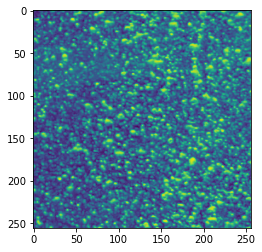

In [20]:
plt.imshow(frame4[0, 0, :, :].cpu().detach().numpy())

In [ ]:
[print(arg) for arg in dir(loss.data)]; # if not arg.startswith('__')] 

In [ ]:
print(type(DistillationLoss))

<class 'type'>


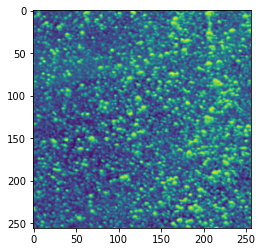

In [19]:
import matplotlib.pyplot as plt
plt.imshow(frame7[0, 0, :, :].cpu().numpy())

torch.Size([2, 3, 256, 256])